<a href="https://colab.research.google.com/github/paciello1899922/CrowdCounting/blob/main/Crowd_Counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
from google.colab import drive
from google.colab.patches import cv2_imshow
from skimage import io

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, ConcatDataset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    


In [ ]:

!unzip /content/drive/MyDrive/DatasetCrowd/jhu_crowd_v2.0.zip


In [3]:
transformer = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((224, 224)),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
)])


#path
trainset_path = '/content/jhu_crowd_v2.0'
testset_path = '/content/jhu_crowd_v2.0/test'
validationset_path = '/content/jhu_crowd_v2.0/val'

#DataLoader
train_loader = DataLoader(
    torchvision.datasets.ImageFolder(trainset_path, transform=transformer),
    batch_size=64, shuffle=False
)


train_loader

In [4]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 3, 224, 224])
torch.Size([64])


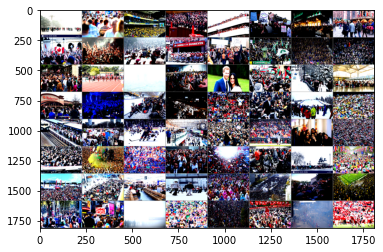

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), aspect='auto')

# show images
imshow(torchvision.utils.make_grid(images))


In [62]:
annotations = pd.read_csv('/content/jhu_crowd_v2.0/train/image_labels.txt', header=None)
img_name = (annotations.loc[0,0])
img_name


1

In [172]:

class CrowdsDataset(Dataset):

  def __init__(self, txt_file, path, heads_path, transform=None):
    self.annotations = pd.read_csv(txt_file, header=None)
    self.path = path
    self.heads_path = heads_path
    self.transform = transform

    self.heads_dimensions = 0
    i = 0
    self.heads = []
    for filename in sorted(os.listdir(heads_path),key=str.lower):
      
      
      
      f = os.path.join(heads_path, filename)
      if os.stat(f).st_size!=0:
        heads_annotations = pd.read_csv(f, delimiter=' ', header=None)
        self.heads_dimensions += len(heads_annotations)
        self.heads.append(np.asarray(heads_annotations.iloc[0:, 0:])) 
      else:
        m = np.array([])
        self.heads.append(m)
        
      i+=1
     
   
    
    
  
    
  
  def __len__(self):
    return len(self.annotations) + self.heads_dimensions #aggiungere 

  def __getitem__(self,index):
    if torch.is_tensor(index):
      index = index.tolist()
    img_name = os.path.join(self.path, str(self.annotations.loc[index,0]).zfill(4)) + '.jpg'
    image = io.imread(img_name)
    total_people = self.annotations.iloc[index,1]
    scene_type = self.annotations.iloc[index,2]
    weather_conditions = self.annotations.iloc[index,3]
    distractor = self.annotations.iloc[index,4]
    heads_locations = self.heads[index]
   
    sample = {'image': image, 'total_people': total_people, 'scene_type': scene_type, 'weather_conditions': weather_conditions, 'distractor': distractor, 'heads_locations': heads_locations}

    if self.transform :
        sample = self.Transform(sample)
    
    return sample




In [176]:
def show_heads(image,heads):
  plt.imshow(image)
  if heads.size!=0:
    plt.scatter(heads[:,0], heads[:,1], s=10, marker='.', c='r')
  plt.pause(0.001)


In [177]:
crowd_dataset = CrowdsDataset(txt_file = '/content/jhu_crowd_v2.0/train/image_labels.txt', path = '/content/jhu_crowd_v2.0/train/images/', heads_path = '/content/jhu_crowd_v2.0/train/gt/')

0 (513, 730, 3) 161 (161, 6)


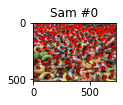

1 (630, 1200, 3) 855 (855, 6)


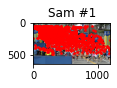

2 (1573, 2048, 3) 455 (455, 6)


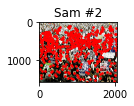

3 (2232, 3348, 3) 7139 (7139, 6)


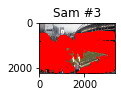

In [180]:

fig = plt.figure()

for i in range (len(crowd_dataset)):
  sample = crowd_dataset[i]

  print(i, sample['image'].shape, sample['total_people'], sample['heads_locations'].shape)
  ax = plt.subplot(1, 4, i + 1)
  plt.tight_layout()
  ax.set_title ('Sam #{}'.format(i))
  show_heads(sample['image'], sample['heads_locations'])

  if i==3:
    plt.show()
    break